In [1]:
#Setting working path required for relative package loading

import os
os.chdir("/home/tales/ds/walmart-recruiting-store-sales-forecasting/")
print("working dir:", "\'" + os.getcwd() + "\'")

working dir: '/home/tales/ds/walmart-recruiting-store-sales-forecasting'


In [2]:
import pandas as pd

from src.data import dao
from src.processment import process
from src.utils import pretties, time_utils, stats
from src.visualization import plot
from bokeh.plotting import show, output_notebook

In [3]:
pretties.max_data_frame_columns()
pretties.decimal_notation()
output_notebook()

Loading BokehJS ...

# <font color="darkred">Relations</font>
with target variable

# walmart-recruiting-store-sales-forecasting
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting

In [4]:
train = dao.load_dataset("train")
train = train.groupby("store_dept").apply(process.train_semantic_enrichment)
train = train.groupby("Store").apply(process.holiday_pre_pos).reset_index(drop=True)

feat = dao.load_features()
feat = process.features_semantic_enrichment(feat)
# feat["celsius_diff"] = feat.groupby("Store").apply(process.temperature_diff)

stores = dao.load_stores()

In [5]:
train = train.merge(feat, how="left", left_on=["Store", "Date"], right_on=["Store", "Date"], suffixes=["", "_y"])
del train["IsHoliday_y"]
del train["timestamp_y"]
train = train.merge(stores, how="left", left_on=["Store"], right_on=["Store"])

In [6]:
cols = ['Date', 'Store', 'Dept', 'Weekly_Sales', 'pre_holiday', 'IsHoliday', 'pos_holiday', 'Fuel_Price', 
        'CPI', 'Unemployment', 'celsius', 'datetime', 'Type', 'sales_diff', 'sales_diff_p',
        'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 
        'Size', 'Temperature', 'timestamp', 'store_dept', "day_n", "week_n", "month_n", "up_diff", "celsius_diff"]

In [7]:
train = train[cols].sort_values("timestamp")

In [8]:
train.sample(6)

,Date,Store,Dept,Weekly_Sales,pre_holiday,IsHoliday,pos_holiday,Fuel_Price,CPI,Unemployment,celsius,datetime,Type,sales_diff,sales_diff_p,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,timestamp,store_dept,day_n,week_n,month_n,up_diff,celsius_diff
176989,2012-01-13,25,40,44762.74,False,False,False,3.51,212.74,6.96,1.44,2012-01-13,B,-2578.60,-0.05,2459.51,10718.26,0.92,506.45,3277.12,128107,34.60,1326423600.00,25_40,13,2,01,False,NaN
241333,2011-08-12,31,4,36618.64,False,False,False,3.64,215.26,7.85,33.51,2011-08-12,A,1068.85,0.03,nan,nan,nan,nan,nan,203750,92.32,1313118000.00,31_4,12,2,08,True,NaN
390325,2012-02-03,6,27,2267.98,True,False,False,3.36,221.77,6.13,14.14,2012-02-03,A,644.99,0.40,36848.38,1772.68,161.55,28199.34,7151.33,202505,57.45,1328238000.00,6_27,3,1,02,True,NaN
222149,2010-11-19,3,34,3684.00,True,False,False,2.77,215.21,7.56,14.29,2010-11-19,B,98.75,0.03,nan,nan,nan,nan,nan,37392,57.72,1290135600.00,3_34,19,3,11,True,NaN
126846,2011-11-04,20,5,48799.61,False,False,False,3.55,210.84,7.08,6.60,2011-11-04,A,5029.18,0.11,nan,nan,nan,nan,nan,203742,43.88,1320375600.00,20_5,4,1,11,True,NaN
367713,2011-02-04,45,16,8142.46,True,False,False,3.23,183.44,8.55,-1.82,2011-02-04,B,-967.67,-0.11,nan,nan,nan,nan,nan,118221,28.73,1296788400.00,45_16,4,1,02,False,NaN


# <font color="navy">Date</font>

In [9]:
grouped_sales = train.groupby("Date")["Weekly_Sales"].median()
p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="navy", title="Weekly_Sales vs Datetime", relative_y_axis=True, height=200)
show(p)

/home/tales/anaconda3/lib/python3.7/site-packages/bokeh/plotting/helpers.py:628: UserWarning: WheelZoomTool are being repeated
  warnings.warn("%s are being repeated" % ",".join(repeated_tools))


In [10]:
# grouped_sales = train.groupby("Date")["sales_diff_p"].median()
# p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="navy", title="sales_diff_p vs Datetime", relative_y_axis=True, height=200)
# show(p)

In [11]:
p = plot.plot_error_values(train, "week_n", "Weekly_Sales", drop_quantile=0.20, 
                           title="Weekly_Sales errors grouped by week_n")
show(p)

In [12]:
# p = plot.plot_error_values(train, "week_n", "sales_diff_p", drop_quantile=0.15, 
#                            title="Weekly_Sales errors grouped by week_n")
# show(p)

In [13]:
train["wm_date"] = train["month_n"] + "/" + train["week_n"].astype(str)

In [14]:
p = plot.plot_error_values(train, "wm_date", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by wm_date", width=1200)
show(p)

In [15]:
# p = plot.plot_error_values(train, "wm_date", "sales_diff_p", drop_quantile=0.25, 
#                            title="sales_diff_p errors grouped by wm_date", width=1200)
# show(p)

# <font color="navy">Store</font>

In [16]:
train.groupby("Store")["Weekly_Sales"].mean().sort_values().plot.bar(title="Sales amout per store", figsize=(10, 3))

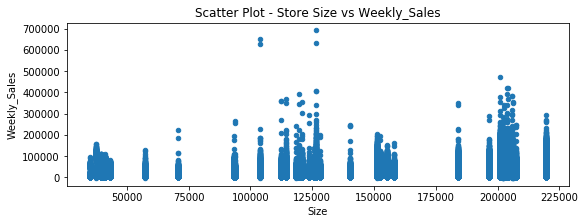

In [17]:
train.plot.scatter("Size", "Weekly_Sales", title="Scatter Plot - Store Size vs Weekly_Sales",figsize=(9,3))

# <font color="navy">IsHoliday</font>
holiday evaluation weight = 5 <br>
not holiday evaluation weight = 1

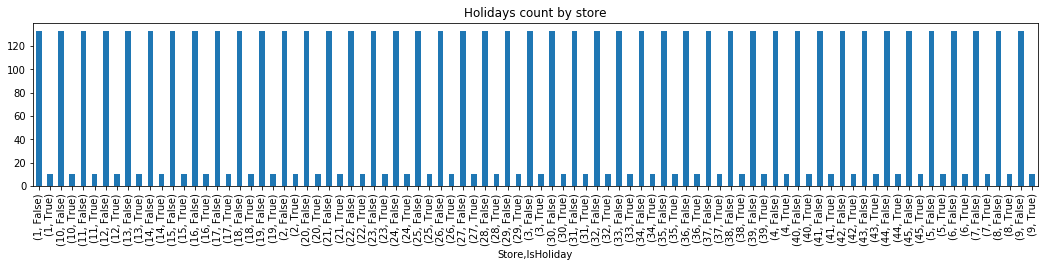

In [18]:
train.drop_duplicates(["Store", "Date"]).groupby("Store")["IsHoliday"].value_counts().plot.bar(title="Holidays count by store",figsize=(18,3))

In [19]:
stats.freq(train.drop_duplicates(["Store", "Date"])["IsHoliday"])

,freq_absolute,freq_relative
False,5985,93.01%
True,450,6.99%


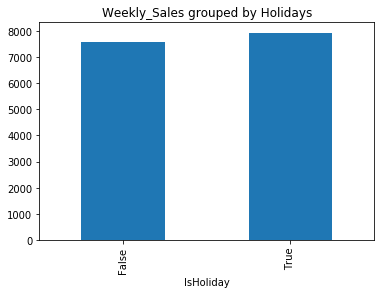

In [20]:
train.groupby("IsHoliday")["Weekly_Sales"].median().plot.bar(title="Weekly_Sales grouped by Holidays")

In [21]:
p = plot.plot_error_values(train, "IsHoliday", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by IsHoliday")
show(p)

#### Before Holiday

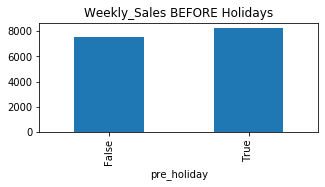

In [22]:
train.groupby("pre_holiday")["Weekly_Sales"].median().plot.bar(title="Weekly_Sales BEFORE Holidays", figsize=(5,2))

In [23]:
p = plot.plot_error_values(train, "pre_holiday", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by pre_holiday", width=350, height=200)
show(p)

#### After Holiday

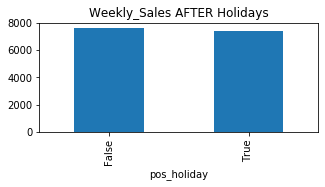

In [24]:
train.groupby("pos_holiday")["Weekly_Sales"].median().plot.bar(title="Weekly_Sales AFTER Holidays", figsize=(5,2))

In [25]:
p = plot.plot_error_values(train, "pos_holiday", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by pos_holiday", width=350, height=200)
show(p)

# <font color="navy">Fuel_Price</font>

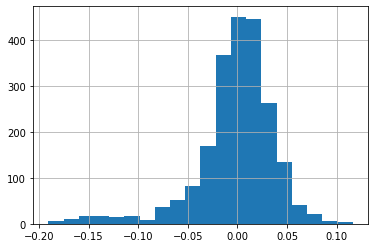

In [26]:
train.groupby(["Store", "wm_date"]).apply(lambda g : g["Fuel_Price"].corr(g["Weekly_Sales"])).hist(bins=20)

It seems that Fuel_Price variation for the same date over years is not strong related to Weekly_Sales variation

# <font color="navy">CPI</font>

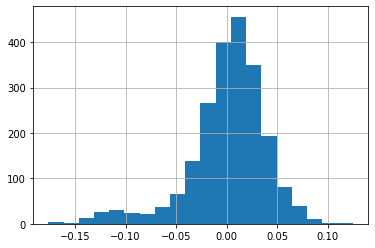

In [27]:
train.groupby(["Store", "wm_date"]).apply(lambda g : g["CPI"].corr(g["Weekly_Sales"])).hist(bins=20)

It seems that Fuel_Price variation for the same date over years is not strong related to Weekly_Sales variation

# <font color="navy">Unemployment</font>

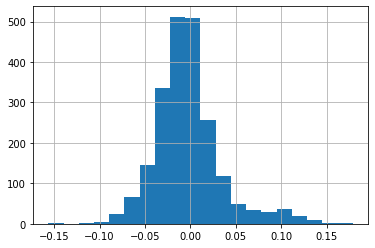

In [28]:
train.groupby(["Store", "wm_date"]).apply(lambda g : g["Unemployment"].corr(g["Weekly_Sales"])).hist(bins=20)

It seems that Fuel_Price variation for the same date over years is not strong related to Weekly_Sales variation

# <font color="navy">Temperature</font>

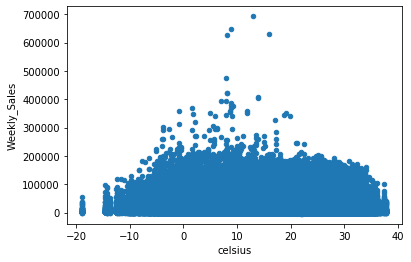

In [29]:
train.plot.scatter("celsius", "Weekly_Sales")

In [30]:
grouped_sales = train.groupby("Date")["celsius"].median()
p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="magenta", title="Temperature vs Datetime", relative_y_axis=True, height=200)
show(p)

/home/tales/anaconda3/lib/python3.7/site-packages/bokeh/plotting/helpers.py:628: UserWarning: WheelZoomTool are being repeated
  warnings.warn("%s are being repeated" % ",".join(repeated_tools))


In [31]:
grouped_sales = train.groupby("Date")["Weekly_Sales"].median()
p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="navy", title="Weekly_Sales vs Datetime", relative_y_axis=True, height=200)
show(p)

In [32]:
train["celsius"].corr(train["Weekly_Sales"])

-0.0023124470102593706

In [33]:
train[train["store_dept"] == "16_5"][["Date", "celsius", "celsius_diff"]]

,Date,celsius,celsius_diff
70764,2010-02-05,-6.78,NaN
70856,2010-02-12,-6.18,NaN
70934,2010-02-19,-6.04,NaN
70944,2010-02-26,-7.71,NaN
71056,2010-03-05,-2.27,NaN
...,...,...,...
79897,2012-09-28,10.78,NaN
79930,2012-10-05,10.26,NaN
79983,2012-10-12,6.26,NaN
80059,2012-10-19,4.77,NaN
